# Projeto 2 de Ciência dos Dados - Predição de crimes em São Francisco

#### Turma 2b
Rafael Kahn<br>
Hélio Zaia<br>
Gabriel Parfan<br>

## Introdução

## Objetivo

## Preparo do dataset

In [15]:
#Bibliotecas
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn
from scipy.stats import norm, uniform, probplot
from sklearn import svm, datasets
from sklearn.utils.multiclass import unique_labels
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.tree import export_graphviz
import graphviz

In [16]:
#Definindo seed
RANDOM_SEED = 13
np.random.seed(RANDOM_SEED)

In [17]:
#função para gerar crosstabs com a correlação entre valores escolhidos
def corrtab_data(data):
        k = [np.corrcoef(data.loc[data.index[a],:],range(0,len(data.columns)))[0,1] for a in range(len(data.index))]
        dic = dict(zip(data.index,k))
        return dic

In [19]:
#Abrindo o dataset
data = pd.read_csv("Crimes_SF.csv")
data.head(10)

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
0,120058272,WEAPON LAWS,POSS OF PROHIBITED WEAPON,Friday,01/29/2016 12:00:00 AM,11:00,SOUTHERN,"ARREST, BOOKED",800 Block of BRYANT ST,-122.403405,37.775421,"(37.775420706711, -122.403404791479)",12005827212120
1,120058272,WEAPON LAWS,"FIREARM, LOADED, IN VEHICLE, POSSESSION OR USE",Friday,01/29/2016 12:00:00 AM,11:00,SOUTHERN,"ARREST, BOOKED",800 Block of BRYANT ST,-122.403405,37.775421,"(37.775420706711, -122.403404791479)",12005827212168
2,141059263,WARRANTS,WARRANT ARREST,Monday,04/25/2016 12:00:00 AM,14:59,BAYVIEW,"ARREST, BOOKED",KEITH ST / SHAFTER AV,-122.388856,37.729981,"(37.7299809672996, -122.388856204292)",14105926363010
3,160013662,NON-CRIMINAL,LOST PROPERTY,Tuesday,01/05/2016 12:00:00 AM,23:50,TENDERLOIN,NONE,JONES ST / OFARRELL ST,-122.412971,37.785788,"(37.7857883766888, -122.412970537591)",16001366271000
4,160002740,NON-CRIMINAL,LOST PROPERTY,Friday,01/01/2016 12:00:00 AM,00:30,MISSION,NONE,16TH ST / MISSION ST,-122.419672,37.765050,"(37.7650501214668, -122.419671780296)",16000274071000
5,160002869,ASSAULT,BATTERY,Friday,01/01/2016 12:00:00 AM,21:35,NORTHERN,NONE,1700 Block of BUSH ST,-122.426077,37.788019,"(37.788018555829, -122.426077177375)",16000286904134
6,160003130,OTHER OFFENSES,PAROLE VIOLATION,Saturday,01/02/2016 12:00:00 AM,00:04,SOUTHERN,"ARREST, BOOKED",MARY ST / HOWARD ST,-122.405721,37.780879,"(37.7808789360214, -122.405721454567)",16000313026150
7,160003259,NON-CRIMINAL,FIRE REPORT,Saturday,01/02/2016 12:00:00 AM,01:02,TENDERLOIN,NONE,200 Block of EDDY ST,-122.411778,37.783981,"(37.7839805592634, -122.411778295992)",16000325968000
8,160003970,WARRANTS,WARRANT ARREST,Saturday,01/02/2016 12:00:00 AM,12:21,SOUTHERN,"ARREST, BOOKED",4TH ST / BERRY ST,-122.393357,37.775788,"(37.7757876218293, -122.393357241451)",16000397063010
9,160003641,MISSING PERSON,FOUND PERSON,Friday,01/01/2016 12:00:00 AM,10:06,BAYVIEW,NONE,100 Block of CAMERON WY,-122.387182,37.720967,"(37.7209669615499, -122.387181635995)",16000364175000


In [20]:
data.Category.value_counts()

LARCENY/THEFT                  40409
OTHER OFFENSES                 19599
NON-CRIMINAL                   17866
ASSAULT                        13577
VANDALISM                       8589
VEHICLE THEFT                   6419
WARRANTS                        5914
BURGLARY                        5802
SUSPICIOUS OCC                  5782
MISSING PERSON                  4338
DRUG/NARCOTIC                   4243
ROBBERY                         3299
FRAUD                           2635
SECONDARY CODES                 1841
TRESPASS                        1812
WEAPON LAWS                     1658
SEX OFFENSES, FORCIBLE           940
STOLEN PROPERTY                  882
RECOVERED VEHICLE                736
DISORDERLY CONDUCT               658
PROSTITUTION                     641
FORGERY/COUNTERFEITING           619
DRUNKENNESS                      465
DRIVING UNDER THE INFLUENCE      378
ARSON                            286
KIDNAPPING                       257
EMBEZZLEMENT                     168
L

In [21]:
#Limpeza Inicial
#Deixando apenas os crimes mais relevantes (inicialmente 4)
data_f = data[(data['Category'] == 'LARCENY/THEFT') | (data['Category'] == 'ASSAULT') | (data['Category'] == 'OTHER OFFENSES') | (data['Category'] == 'VEHICLE THEFT')]
data_f.head(5)

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
5,160002869,ASSAULT,BATTERY,Friday,01/01/2016 12:00:00 AM,21:35,NORTHERN,NONE,1700 Block of BUSH ST,-122.426077,37.788019,"(37.788018555829, -122.426077177375)",16000286904134
6,160003130,OTHER OFFENSES,PAROLE VIOLATION,Saturday,01/02/2016 12:00:00 AM,00:04,SOUTHERN,"ARREST, BOOKED",MARY ST / HOWARD ST,-122.405721,37.780879,"(37.7808789360214, -122.405721454567)",16000313026150
10,160086863,LARCENY/THEFT,ATTEMPTED THEFT FROM LOCKED VEHICLE,Friday,01/29/2016 12:00:00 AM,22:30,TARAVAL,NONE,1200 Block of 19TH AV,-122.477377,37.764478,"(37.7644781578695, -122.477376524003)",16008686306240
12,160073014,OTHER OFFENSES,RESISTING ARREST,Monday,01/25/2016 12:00:00 AM,23:20,BAYVIEW,"ARREST, BOOKED",200 Block of HUNTERSPOINT BL,-122.376758,37.735697,"(37.7356970275482, -122.37675765553)",16007301427170
13,140776777,ASSAULT,AGGRAVATED ASSAULT WITH A GUN,Thursday,09/15/2016 12:00:00 AM,07:40,INGLESIDE,"ARREST, BOOKED",SILVER AV / CAMELLIA AV,-122.432326,37.729271,"(37.7292705199592, -122.432325871028)",14077677704011


## Análise Exploratória


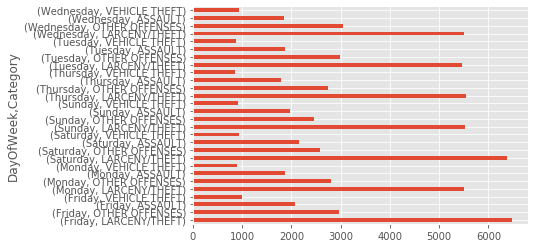

In [22]:
data_f.groupby('DayOfWeek').Category.value_counts().plot.barh()
plt.style.use("ggplot")
plt.grid(True)

In [23]:
tabela_ds = pd.crosstab(data_f.Category, data_f.DayOfWeek, normalize = 'index')
tabela_ds

DayOfWeek,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
Category,,,,,,,
ASSAULT,0.153348,0.137365,0.158872,0.144804,0.131251,0.137954,0.136407
LARCENY/THEFT,0.160286,0.136183,0.157985,0.136875,0.137049,0.135440,0.136183
OTHER OFFENSES,0.151742,0.143171,0.131792,0.125261,0.140415,0.152457,0.155161
VEHICLE THEFT,0.155632,0.140676,0.145817,0.142546,0.133354,0.137249,0.144727


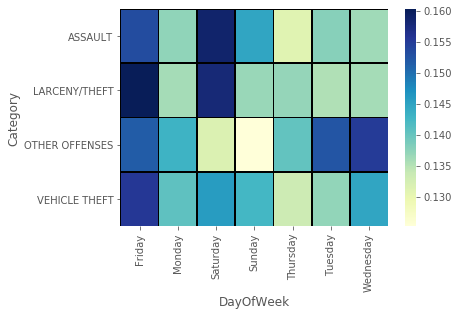

In [24]:
seaborn.heatmap(tabela_ds, annot = False, fmt = 'd',linecolor="blacK",linewidth=.5,cmap='YlGnBu');

In [25]:
tabela_ho = pd.crosstab(data_f.Category, data_f.Time, normalize = 'index')
tabela_ho.head(10)

Time,00:01,00:02,00:03,00:04,00:05,00:06,00:07,00:08,00:09,00:10,...,23:50,23:51,23:52,23:53,23:54,23:55,23:56,23:57,23:58,23:59
Category,,,,,,,,,,,,,,,,,,,,,
ASSAULT,0.015762,0.000368,0.000589,0.000074,0.001105,0.000295,0.000295,0.000884,0.000074,0.001178,...,0.001841,0.000884,0.000442,0.000147,0.000442,0.000663,0.000074,0.000074,0.000368,0.000663
LARCENY/THEFT,0.018709,0.000173,0.000124,0.000173,0.001262,0.000099,0.000025,0.000148,0.000049,0.000495,...,0.001213,0.000025,0.000049,0.000099,0.000173,0.000841,0.000000,0.000049,0.000198,0.000693
OTHER OFFENSES,0.033522,0.000510,0.000408,0.000561,0.001990,0.000765,0.000561,0.000510,0.000663,0.001531,...,0.001582,0.000408,0.000459,0.000408,0.000510,0.001020,0.000459,0.000612,0.000204,0.000561
VEHICLE THEFT,0.020876,0.000156,0.000000,0.000000,0.000779,0.000000,0.000000,0.000156,0.000156,0.000623,...,0.000935,0.000000,0.000000,0.000000,0.000000,0.000623,0.000000,0.000000,0.000000,0.002181


In [26]:
#horario = tabela_ho.columns  

data_f["Hour"] = data_f.Time.str.slice(0,3) + "00"
    
data_f["Hour"].value_counts()
tabela_Category_Time = pd.crosstab(data_f.Category, data_f.Hour, normalize='index')
tabela_Category_Time

C:\Users\gabri\AppData\Roaming\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Hour,00:00,01:00,02:00,03:00,04:00,05:00,06:00,07:00,08:00,09:00,...,14:00,15:00,16:00,17:00,18:00,19:00,20:00,21:00,22:00,23:00
Category,,,,,,,,,,,,,,,,,,,,,
ASSAULT,0.048612,0.043088,0.039552,0.023348,0.015025,0.010533,0.017603,0.026074,0.033365,0.036385,...,0.046991,0.055903,0.055535,0.058039,0.051779,0.051337,0.054651,0.059070,0.048538,0.046476
LARCENY/THEFT,0.034423,0.025415,0.016110,0.009676,0.006682,0.007449,0.010913,0.015318,0.027073,0.032196,...,0.053948,0.054122,0.058626,0.068772,0.080477,0.080304,0.070009,0.056374,0.047588,0.042812
OTHER OFFENSES,0.067912,0.029338,0.023215,0.018981,0.013470,0.009439,0.012858,0.027042,0.042298,0.042298,...,0.049798,0.057605,0.059646,0.063371,0.056023,0.047758,0.040308,0.038471,0.046533,0.045564
VEHICLE THEFT,0.034585,0.026328,0.016669,0.011061,0.008880,0.010438,0.019629,0.025705,0.033339,0.034429,...,0.037701,0.040972,0.052656,0.073064,0.083969,0.073687,0.080542,0.072597,0.076803,0.062627


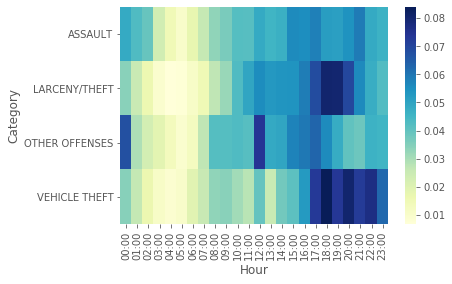

In [27]:
seaborn.heatmap(tabela_Category_Time, annot = False, fmt = 'd', cmap='YlGnBu');

In [28]:
Corr_Category_Hour = corrtab_data(tabela_Category_Time)
tabela_Corr_Category_Hour = pd.DataFrame([Corr_Category_Hour])
tabela_Corr_Category_Hour

,ASSAULT,LARCENY/THEFT,OTHER OFFENSES,VEHICLE THEFT
0,0.657891,0.785558,0.466086,0.862514


In [30]:
tabela_Category_District = pd.crosstab(data_f.Category, data_f.PdDistrict, normalize = 'index')
tabela_Category_District

PdDistrict,BAYVIEW,CENTRAL,INGLESIDE,MISSION,NORTHERN,PARK,RICHMOND,SOUTHERN,TARAVAL,TENDERLOIN
Category,,,,,,,,,,
ASSAULT,0.130736,0.087427,0.110923,0.155410,0.113133,0.038595,0.034838,0.173234,0.067614,0.088090
LARCENY/THEFT,0.058330,0.166799,0.044075,0.082187,0.178653,0.055039,0.077534,0.227752,0.064467,0.045164
OTHER OFFENSES,0.120057,0.088627,0.095260,0.152559,0.113220,0.055462,0.052146,0.170213,0.089341,0.063115
VEHICLE THEFT,0.168406,0.074934,0.142546,0.145194,0.115127,0.070416,0.080231,0.095498,0.083814,0.023835


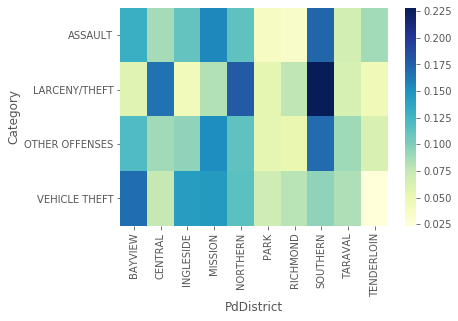

In [31]:
seaborn.heatmap(tabela_Category_District, annot = False, fmt = 'd', cmap='YlGnBu');

In [32]:
tabela_Hour_District = pd.crosstab(data_f.PdDistrict, data_f.Hour, normalize = 'index')
tabela_Hour_District

Hour,00:00,01:00,02:00,03:00,04:00,05:00,06:00,07:00,08:00,09:00,...,14:00,15:00,16:00,17:00,18:00,19:00,20:00,21:00,22:00,23:00
PdDistrict,,,,,,,,,,,,,,,,,,,,,
BAYVIEW,0.045467,0.024451,0.017843,0.016257,0.013349,0.010177,0.017314,0.024319,0.044277,0.037801,...,0.043087,0.043748,0.053132,0.061195,0.074015,0.070975,0.061856,0.059741,0.051811,0.048242
CENTRAL,0.039034,0.024051,0.022770,0.011434,0.006407,0.008280,0.009266,0.017053,0.027896,0.034993,...,0.058255,0.055495,0.060030,0.070478,0.076589,0.069492,0.066437,0.053031,0.048595,0.037654
INGLESIDE,0.054704,0.032625,0.022574,0.017960,0.011699,0.011040,0.013511,0.022244,0.035261,0.039545,...,0.043829,0.051244,0.053386,0.060636,0.063272,0.063602,0.062613,0.061130,0.057176,0.052727
MISSION,0.054100,0.043302,0.029082,0.021170,0.013365,0.008874,0.016893,0.022025,0.032503,0.034748,...,0.045761,0.050786,0.053352,0.063402,0.064364,0.056880,0.057415,0.051641,0.058056,0.054635
NORTHERN,0.041919,0.034150,0.022624,0.017075,0.010843,0.007513,0.013831,0.017929,0.032699,0.036114,...,0.047127,0.052335,0.055665,0.062495,0.071886,0.071288,0.065910,0.053103,0.049688,0.048579
PARK,0.029858,0.025659,0.018428,0.008631,0.011430,0.006765,0.015395,0.024259,0.033357,0.039655,...,0.050618,0.056916,0.065780,0.066247,0.061582,0.060182,0.059249,0.054817,0.048985,0.042454
RICHMOND,0.039860,0.018083,0.016138,0.005833,0.007389,0.006805,0.007972,0.015555,0.028388,0.030916,...,0.061637,0.064748,0.058526,0.069998,0.072720,0.070970,0.060859,0.052304,0.040832,0.031694
SOUTHERN,0.048439,0.028767,0.022575,0.011287,0.007998,0.007224,0.011868,0.021736,0.027864,0.033540,...,0.051600,0.056566,0.060823,0.071788,0.070949,0.070627,0.057340,0.050890,0.047794,0.047601
TARAVAL,0.046800,0.025120,0.015141,0.013765,0.009635,0.008087,0.011700,0.022368,0.036476,0.036992,...,0.055058,0.055231,0.053338,0.060392,0.065382,0.069683,0.065210,0.057811,0.051961,0.044219


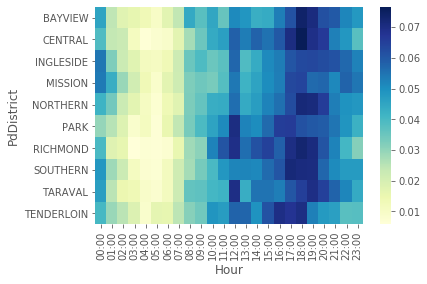

In [33]:
seaborn.heatmap(tabela_Hour_District, annot = False, fmt = 'd', cmap='YlGnBu');

In [34]:
Corr_Hour_District = corrtab_data(tabela_Hour_District)

tabela_Corr_Hour_District = pd.DataFrame([Corr_Hour_District])
tabela_Corr_Hour_District

,BAYVIEW,CENTRAL,INGLESIDE,MISSION,NORTHERN,PARK,RICHMOND,SOUTHERN,TARAVAL,TENDERLOIN
0,0.787455,0.745778,0.757947,0.702664,0.767471,0.769941,0.678071,0.734609,0.755545,0.63442


In [35]:
tabela_DayOfWeek_Hour = pd.crosstab(data_f.DayOfWeek, data_f.Hour, normalize = 'index')

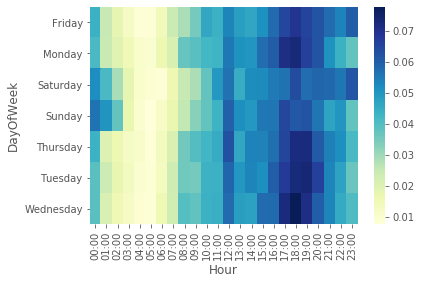

In [36]:
seaborn.heatmap(tabela_DayOfWeek_Hour, annot = False, fmt = 'd', cmap='YlGnBu');

In [37]:
Corr_DayOfWeek_Hour = corrtab_data(tabela_DayOfWeek_Hour)

tabela_Corr_DayOfWeek_Hour = pd.DataFrame([Corr_DayOfWeek_Hour])
tabela_Corr_DayOfWeek_Hour

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,0.836512,0.731121,0.734373,0.538155,0.765946,0.755492,0.757657


In [38]:
tabela_DayOfWeek_District =  pd.crosstab(data_f.DayOfWeek, data_f.PdDistrict, normalize = 'index')

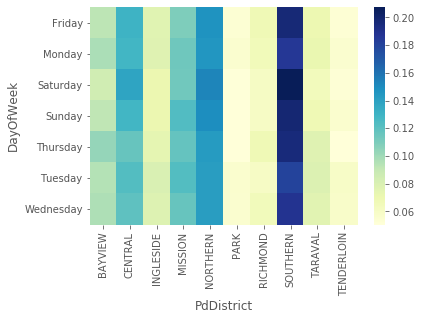

In [39]:
seaborn.heatmap(tabela_DayOfWeek_District, annot = False, fmt = 'd', cmap='YlGnBu');

## Classificador

In [40]:
data_f = data_f.drop('Date', 1)
data_f = data_f.drop('Location', 1)

In [41]:
#Obtendo frequência relativa das categorias
data_f.Category.value_counts(True)

LARCENY/THEFT     0.505087
OTHER OFFENSES    0.244975
ASSAULT           0.169704
VEHICLE THEFT     0.080233
Name: Category, dtype: float64

In [43]:
data_f = data_f.dropna()

In [44]:
categorical_feature_mask = data_f.dtypes==object
categorical_cols = data_f.columns[categorical_feature_mask].tolist()
le = LabelEncoder()
data_f[categorical_cols] = data_f[categorical_cols].apply(lambda col: le.fit_transform(col))
categorical_features = categorical_feature_mask
ohe = OneHotEncoder(categorical_features, sparse=False)

In [45]:
#data_f_ohe = ohe.fit_transform(data_f)

In [46]:
data_f.head()

,IncidntNum,Category,Descript,DayOfWeek,Time,PdDistrict,Resolution,Address,X,Y,PdId,Hour
5,160002869,0,37,0,1290,4,7,3145,-122.426077,37.788019,16000286904134,21
6,160003130,2,140,2,3,7,0,11811,-122.405721,37.780879,16000313026150,0
10,160086863,1,32,0,1345,8,7,2044,-122.477377,37.764478,16008686306240,22
12,160073014,2,173,1,1395,0,0,3941,-122.376758,37.735697,16007301427170,23
13,140776777,0,5,4,455,2,0,13164,-122.432326,37.729271,14077677704011,7


In [47]:
x = data_f[['DayOfWeek', 'Hour', 'PdDistrict', 'Address', 'X', 'Y', 'PdId']]
y = data_f['Category']

In [48]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=152)

In [49]:
model = RandomForestClassifier(n_estimators=100)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print('Acurácia: {:.3f} %'.format(accuracy_score(y_test, y_pred)*100))

Acurácia: 63.118 %


In [50]:
matriz = pd.crosstab(y_test, y_pred, normalize = 'index')
matriz

col_0,0,1,2,3
Category,,,,
0,0.413851,0.253378,0.308880,0.023890
1,0.063203,0.805510,0.115321,0.015966
2,0.155818,0.250299,0.559542,0.034341
3,0.124739,0.276096,0.378914,0.220251


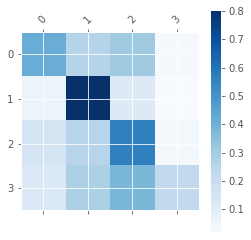

In [51]:
def plot_confusion_matrix(df_confusion, cmap=plt.cm.Blues):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)

#Plotando o gráfico
plot_confusion_matrix(matriz)

## Conclusão

## Fontes:

https://towardsdatascience.com/encoding-categorical-features-21a2651a065c<br>
https://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn<br>
https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py<br>
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html